# Spatial mapping of cell types in the slide-seq data

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['savefig.dpi'] = 250



data_type = 'float32'

# this line forces theano to use the GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

from matplotlib import rcParams
import seaborn as sns
import pickle

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /nfs/users/nfs_v/vk7/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.10-64/tmpbt1lwx8v/key.pkl
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '62618' (I am process '63703')
/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 8201 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


# S12b 

### SlideSeq <a class="anchor" id="read"></a> 

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/stickels_et_al_2020_slide_seqV2/'
results_folder2 = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/results/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/'

sc_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/regression_model/'

run_name = f'signatures_v3_Adam_lr0002_alpha20_pyro_ref/'
sp_results_folder = f'{results_folder}{run_name}/'

fig_path = f'{sp_results_folder}/plots/'
sc.settings.figdir = fig_path

In [3]:
adata_vis = anndata.read(f'{sp_results_folder}sp.h5ad')

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

adata_vis.uns['spatial'] = {k: None for k in adata_vis.obs['filename'].unique()}
adata_vis.obsm['spatial'] = np.array([-adata_vis.obs['xcoord'], adata_vis.obs['ycoord']]).T

total_counts = np.array(adata_vis.X.sum(1))[:, 0]
adata_vis = adata_vis[total_counts < np.quantile(total_counts, 0.995)]

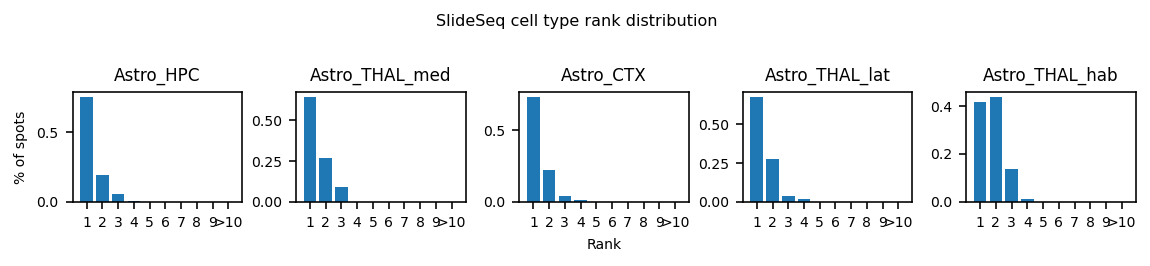

In [4]:
mean_cols = adata_vis.uns['mod']['factor_names']
mean_spot = adata_vis.obs[mean_cols]

def plot_10_first(series, n=10):
    series = series.sort_index().reindex(range(0, max(n, series.index.max())), fill_value=0)
    x = series.index[:n] + 1
    x = x.values
    y = series.values
    y[n-1] += y[n-1:].sum()
    y = y[:n]
    y = y/y.sum()
    
    plt.xticks(range(1, n+1), list(range(1, n)) + [f'>{n}'])

    plt.bar(x, y)

def to_rank(a):
    return (-a).argsort(axis=1).argsort(axis=1)

rank_df = mean_spot.copy()


rank_df[:] = to_rank(rank_df.values)

# genes_of_interest = [c for c in mean_cols if 'Astro' in c]
genes_of_interest = ['Astro_HPC', 'Astro_THAL_med', 'Astro_CTX', 
                     'Astro_THAL_lat',  'Astro_THAL_hab']


plt.figure(figsize=(8, 1.7))
    
plt.suptitle('SlideSeq cell type rank distribution', y=1.015, size=8)
    
for num, gene in enumerate(genes_of_interest):
    plt.subplot(1, 5, num + 1)
    plt.title(gene.replace('mean_nUMI_factors', ''))
    tmp = rank_df[mean_spot[gene] > 0.4]
    plot_10_first(tmp[gene].value_counts(sort=False).sort_index())
    if num == 2:
        plt.xlabel('Rank')
    if num == 0:
        plt.ylabel('% of spots')
plt.tight_layout()
plt.savefig(f'{fig_path}S12b_slideseq_astro.pdf', bbox_inches='tight')

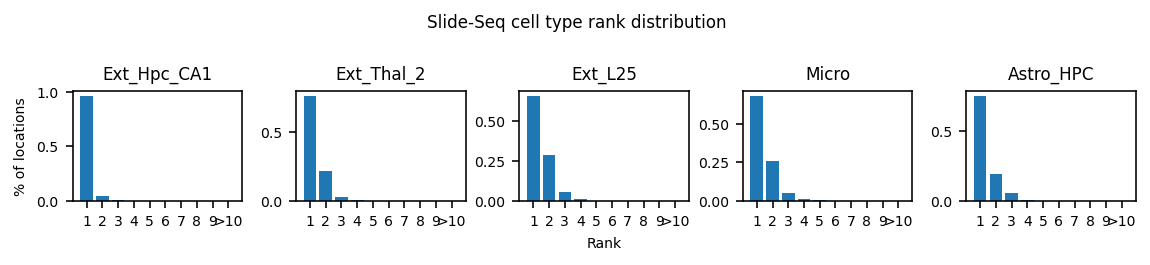

In [5]:
rank_df = mean_spot.copy()


rank_df[:] = to_rank(rank_df.values)

# genes_of_interest = [c for c in mean_cols if 'Astro' in c]
genes_of_interest = ['Ext_Hpc_CA1', 'Ext_Thal_2', 
                     'Ext_L25', 
                     'Micro',  'Astro_HPC']


plt.figure(figsize=(8, 1.7))
    
plt.suptitle('Slide-Seq cell type rank distribution', y=1.013)
    
for num, gene in enumerate(genes_of_interest):
    plt.subplot(1, 5, num + 1)
    plt.title(gene.replace('mean_nUMI_factors', ''))
    tmp = rank_df[mean_spot[gene] > 0.4]
    plot_10_first(tmp[gene].value_counts(sort=False).sort_index())
    if num == 2:
        plt.xlabel('Rank')
    if num == 0:
        plt.ylabel('% of locations')
plt.tight_layout()
plt.savefig(f'{fig_path}S12c_slideseq.pdf', bbox_inches='tight')

Trying to set attribute `.obs` of view, copying.


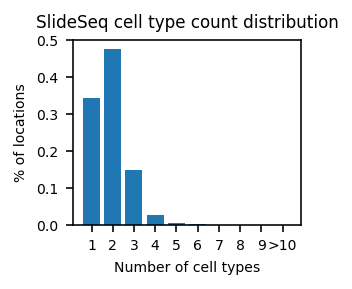

In [6]:
adata_vis.obs['cell_types_count'] = (adata_vis.obs[mean_cols].values > 0.4).sum(axis=1)
type_conts = adata_vis.obs['cell_types_count'].value_counts()

plt.figure(figsize=(8.2/4, 1.7))

plot_10_first(type_conts.sort_index())

plt.title('SlideSeq cell type count distribution')
plt.xlabel('Number of cell types')
plt.ylabel('% of locations');

plt.savefig(f'{fig_path}S12b_slideseq_distribution.pdf', bbox_inches='tight')

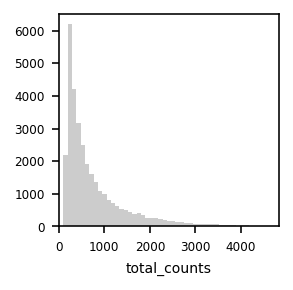

In [7]:
adata_vis.obs['total_counts'] = adata_vis.X.sum(1)
adata_vis.obs['n_genes_by_counts'] = (adata_vis.X > 0).sum(1)

#plt.figure(figsize=(2.7, 3))
fig, axs = plt.subplots(1, 1, figsize=(8.2/4, 2))
sns.distplot(adata_vis.obs['total_counts'], 
                 kde=False, ax = axs, color='grey')
axs.set_xlim(0, adata_vis.obs['total_counts'].max())
axs.set_xlabel('total_counts', size=7)
plt.tick_params(labelsize=6, axis='y')
plt.tick_params(labelsize=6, axis='x')
    
#sns.distplot(adata_vis.obs['n_genes_by_counts'],
#             kde=False, bins=60, ax = axs[1])
#axs[1].set_xlim(0, adata_vis.obs['n_genes_by_counts'].max())
#axs[1].set_xlabel('n_genes_by_counts', size=7)
#plt.tick_params(labelsize=6, axis='y')
#plt.tick_params(labelsize=6, axis='x')
plt.tight_layout()
plt.savefig(f'{fig_path}SlideSeqV2_total_counts.pdf', bbox_inches='tight')

# S12a 

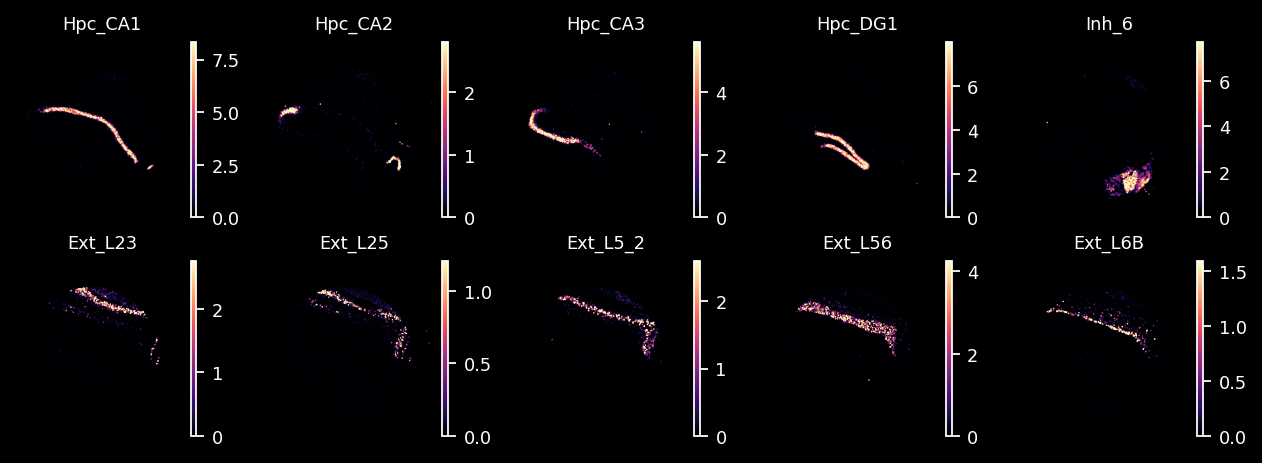

<Figure size 120x120 with 0 Axes>

In [8]:
sc.settings.set_figure_params(vector_friendly = True, format = 'pdf', fontsize=8, dpi_save = 700)

sel_clust = ['Ext_Hpc_CA1', 'Ext_Hpc_CA2', 'Ext_Hpc_CA3', 'Ext_Hpc_DG1',
             'Inh_6', 'Ext_L23', 'Ext_L25', 'Ext_L5_2', 'Ext_L56', 'Ext_L6B']

sel_clust_lab = ['Hpc_CA1', 'Hpc_CA2', 'Hpc_CA3', 'Hpc_DG1', 'Inh_6',
             'Ext_L23', 'Ext_L25', 'Ext_L5_2', 'Ext_L56', 'Ext_L6B']

sel_clust_col = ['' + str(i) for i in sel_clust]

with plt.style.context('dark_background'):
    with matplotlib.rc_context({'axes.facecolor':  'black', 'figure.figsize': [1.5, 1.5], 'font.size': 8}):
        sc.pl.spatial(adata_vis, img_key = None, cmap='magma',
                      title=sel_clust_lab,
                      color=sel_clust_col, 
                      vmin=0, vmax='p99.7',
                      ncols=5, spot_size=50,
                      gene_symbols='SYMBOL', frameon=False, wspace=0.26, save=f'S12a.pdf')
        plt.tight_layout();
    plt.show()
    
matplotlib.rc_file_defaults()
matplotlib.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['savefig.dpi'] = 250

###  Visium

In [9]:
# read a previously trained 
c2l_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'
results_folder_allen = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_brain_allen/'
sp_results_folder = f'{c2l_results_folder}scvi/'
sc_results_folder = f'{c2l_results_folder}regression_model/'

run_name = 'v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_200alphatest'

sp_data_file = f'{sp_results_folder}{run_name}/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

slide = adata_vis[adata_vis.obs["sample"]==adata_vis.obs["sample"].unique()[0]]

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'
fig_path


'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_200alphatest/figures/'

In [10]:
mean_cols = adata_vis.uns['mod']['factor_names']
mean_spot = adata_vis.obs[mean_cols]

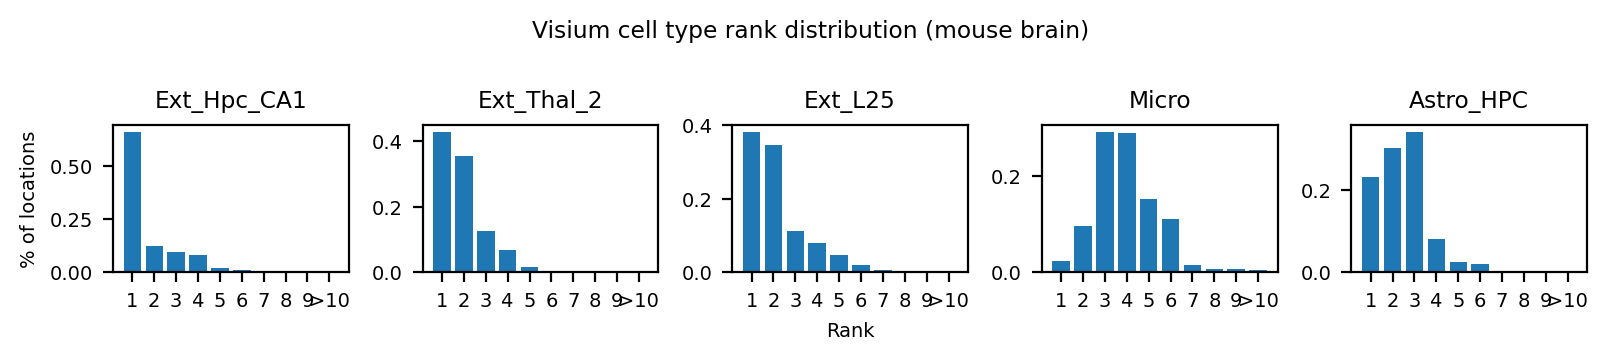

In [11]:
rank_df = mean_spot.copy()


rank_df[:] = to_rank(rank_df.values)

# genes_of_interest = [c for c in mean_cols if 'Astro' in c]
genes_of_interest = ['Ext_Hpc_CA1', 'Ext_Thal_2', 
                     'Ext_L25', 
                     'Micro',  'Astro_HPC']

plt.figure(figsize=(8, 1.7))
    
plt.suptitle('Visium cell type rank distribution (mouse brain)', y=1.013)
    
for num, gene in enumerate(genes_of_interest):
    plt.subplot(1, 5, num + 1)
    plt.title(gene.replace('mean_spot_factors', ''))
    tmp = rank_df[mean_spot[gene] > 0.5]
    plot_10_first(tmp[gene].value_counts(sort=False).sort_index())
    if num == 2:
        plt.xlabel('Rank')
    if num == 0:
        plt.ylabel('% of locations')
plt.tight_layout()
plt.savefig(f'{fig_path}S12c_visium.pdf', bbox_inches='tight')

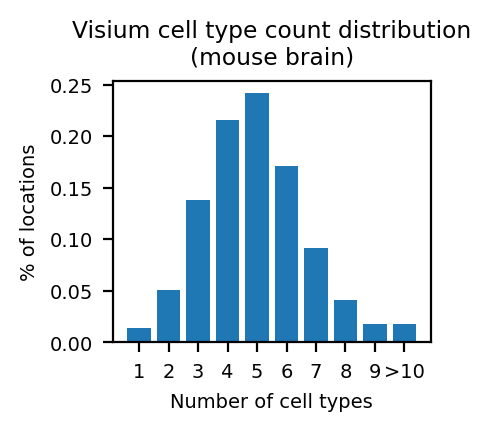

In [12]:
#mean_cols = [c for c in adata_vis.obs.columns if 'mean_spot_factors' in c]
#mean_spot = adata_vis.obs[mean_cols]

adata_vis.obs['cell_types_count'] = (adata_vis.obs[mean_cols].values > 0.4).sum(axis=1)
type_conts = adata_vis.obs['cell_types_count'].value_counts()

plt.figure(figsize=(8.2/4, 1.7))

plot_10_first(type_conts.sort_index())

plt.title('Visium cell type count distribution\n(mouse brain)')
plt.xlabel('Number of cell types')
plt.ylabel('% of locations');

plt.savefig(f'{fig_path}S12b_visium_distribution.pdf', bbox_inches='tight')

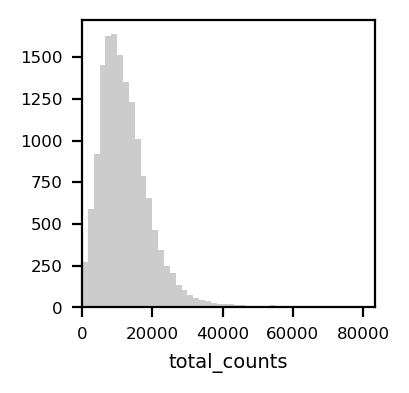

In [13]:
adata_vis.obs['total_counts'] = adata_vis.X.sum(1)
adata_vis.obs['n_genes_by_counts'] = (adata_vis.X > 0).sum(1)

#plt.figure(figsize=(2.7, 3))
fig, axs = plt.subplots(1, 1, figsize=(8.2/4, 2))
sns.distplot(adata_vis.obs['total_counts'], 
                 kde=False, ax = axs, color='grey')
axs.set_xlim(0, adata_vis.obs['total_counts'].max())
axs.set_xlabel('total_counts', size=7)
plt.tick_params(labelsize=6, axis='y')
plt.tick_params(labelsize=6, axis='x')
    
#sns.distplot(adata_vis.obs['n_genes_by_counts'],
#             kde=False, bins=60, ax = axs[1])
#axs[1].set_xlim(0, adata_vis.obs['n_genes_by_counts'].max())
#axs[1].set_xlabel('n_genes_by_counts', size=7)
#plt.tick_params(labelsize=6, axis='y')
#plt.tick_params(labelsize=6, axis='x')
plt.tight_layout()
plt.savefig(f'{fig_path}Mouse_Brain_total_counts.pdf', bbox_inches='tight')

###  Lymph node

In [20]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

scvi_run_name = 'signatures_lr0002_Adam_long_v0ref_30kiter_c2l'
scvi_ref_run_name = 'signatures_lr0002_Adam_ref'
scvi_run_path = f'{results_folder}pyro_model/{scvi_run_name}/'
scvi_ref_run_path = f'{results_folder}pyro_model/{scvi_ref_run_name}/'

# path for saving figures
fig_path = f'{scvi_run_path}plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

adata_vis = sc.read_h5ad(f'{scvi_run_path}sp.h5ad')

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

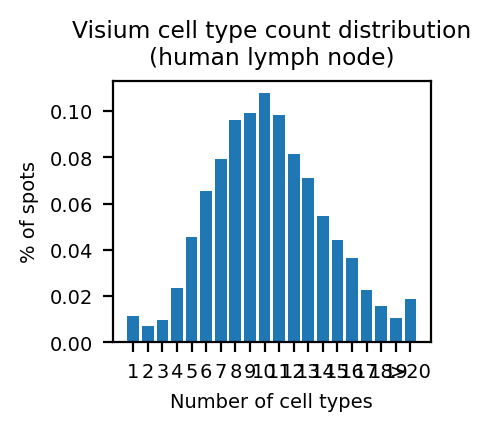

In [21]:
mean_cols = adata_vis.uns['mod']['factor_names']
mean_spot = adata_vis.obs[mean_cols]

adata_vis.obs['cell_types_count'] = (mean_spot > 0.8).sum(axis=1)
type_conts = adata_vis.obs['cell_types_count'].value_counts()

plt.figure(figsize=(8.2/4, 1.7))

plot_10_first(type_conts.sort_index(), n=20)

plt.title('Visium cell type count distribution\n(human lymph node)')
plt.xlabel('Number of cell types')
plt.ylabel('% of spots');

plt.savefig(f'{fig_path}S12b_lymph_node_distribution.pdf', bbox_inches='tight')

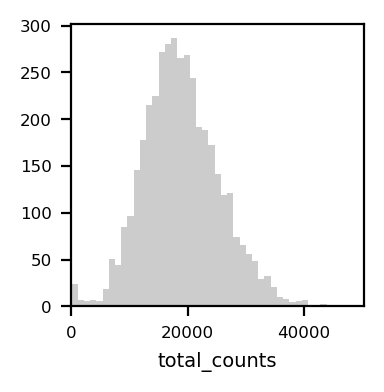

In [22]:
adata_vis.obs['total_counts'] = adata_vis.X.sum(1)
adata_vis.obs['n_genes_by_counts'] = (adata_vis.X > 0).sum(1)

#plt.figure(figsize=(2.7, 3))
fig, axs = plt.subplots(1, 1, figsize=(8.2/4, 2))
sns.distplot(adata_vis.obs['total_counts'], 
                 kde=False, ax = axs, color='grey')
axs.set_xlim(0, adata_vis.obs['total_counts'].max())
axs.set_xlabel('total_counts', size=7)
plt.tick_params(labelsize=6, axis='y')
plt.tick_params(labelsize=6, axis='x')
    
#sns.distplot(adata_vis.obs['n_genes_by_counts'],
#             kde=False, bins=60, ax = axs[1])
#axs[1].set_xlim(0, adata_vis.obs['n_genes_by_counts'].max())
#axs[1].set_xlabel('n_genes_by_counts', size=7)
#plt.tick_params(labelsize=6, axis='y')
#plt.tick_params(labelsize=6, axis='x')
plt.tight_layout()
plt.savefig(f'{fig_path}LN_total_counts_v2.pdf', bbox_inches='tight')

###  Adult gut

In [17]:
# read a previously trained LocationModel
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/Visium/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

# Set paths to data and results used through the document:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/oxford_visium/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/'
annotations_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/tissue_annotation/oxford/'
sc_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/gut/'

regression_model_output = 'v1_ye_signatures_lr0002_Adam'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'
## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

run_name = 'c2l_v3_nonamortised_fulldata_epochs20k_lr0002_Adam_oxford_adult_paed_ref_signatures_N25_alphatest20'
scvi_run_name = f'{results_folder}/{run_name}'

# path for saving figures
fig_path = f'{results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{results_folder}{run_name}/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

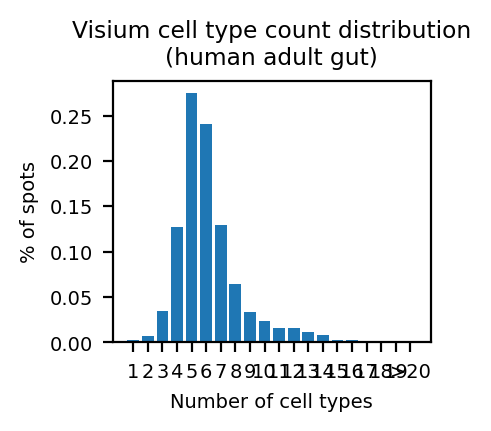

In [18]:
mean_cols = adata_vis.uns['mod']['factor_names']
mean_spot = adata_vis.obs[mean_cols]

adata_vis.obs['cell_types_count'] = (mean_spot > 0.5).sum(axis=1)
type_conts = adata_vis.obs['cell_types_count'].value_counts()

plt.figure(figsize=(8.2/4, 1.7))

plot_10_first(type_conts.sort_index(), n=20)

plt.title('Visium cell type count distribution\n(human adult gut)')
plt.xlabel('Number of cell types')
plt.ylabel('% of spots');

plt.savefig(f'{fig_path}S12b_gut_distribution.pdf', bbox_inches='tight')

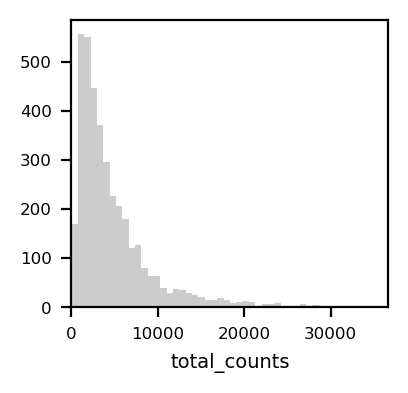

In [19]:
adata_vis.obs['total_counts'] = adata_vis.X.sum(1)
adata_vis.obs['n_genes_by_counts'] = (adata_vis.X > 0).sum(1)

#plt.figure(figsize=(2.7, 3))
fig, axs = plt.subplots(1, 1, figsize=(8.2/4, 2))
sns.distplot(adata_vis.obs['total_counts'], 
                 kde=False, ax = axs, color='grey')
axs.set_xlim(0, adata_vis.obs['total_counts'].max())
axs.set_xlabel('total_counts', size=7)
plt.tick_params(labelsize=6, axis='y')
plt.tick_params(labelsize=6, axis='x')
    
#sns.distplot(adata_vis.obs['n_genes_by_counts'],
#             kde=False, bins=60, ax = axs[1])
#axs[1].set_xlim(0, adata_vis.obs['n_genes_by_counts'].max())
#axs[1].set_xlabel('n_genes_by_counts', size=7)
#plt.tick_params(labelsize=6, axis='y')
#plt.tick_params(labelsize=6, axis='x')
plt.tight_layout()
plt.savefig(f'{fig_path}adult_gut_total_counts.pdf', bbox_inches='tight')